In [20]:
import os
import glob
import pickle
import time
import json

os.environ["PRIVBAYES_BIN"] = "./ydnpd/harness/synthesis/privbayes/mac_bin"

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display, Markdown


import ydnpd
from additional import ADDITIONAL_EXPERIMENTS, ADDITIONAL_PATH
from ydnpd import EVALUATION_METRICS, ALL_EXPERIMENTS, Experiments

ADDITIONAL_DATASETS = sum(list(ADDITIONAL_EXPERIMENTS.values()), [])

with open("./results/harness.pkl", "rb") as f:
    utility_tasks_results = pickle.load(f)

for x in utility_tasks_results:
    if type(x["evaluation"]["error_rate_diff"]) == list:
        assert len(x["evaluation"]["error_rate_diff"]) == 1
        x["evaluation"]["error_rate_diff"] = x["evaluation"]["error_rate_diff"][0]

In [21]:
# keep only results where dataset name contains "acs"
# acs_results = [x for x in utility_tasks_results if "acs" in x["dataset_name"].lower()]
utility_tasks_results = utility_tasks_results
# also get rid of results where synth is gem
utility_tasks_results = [x for x in utility_tasks_results if x["synth_name"] != "gem"]

In [22]:
# check which metrics are nan for which datasets
# NOTE: there are some datasets for which there are more nans. we will just not include...
missing_metrics = {}
for x in utility_tasks_results:
    for metric in EVALUATION_METRICS:
        if np.isnan(x["evaluation"][metric]):
            missing_metrics[x["dataset_name"]] = missing_metrics.get(x["dataset_name"], []) + [metric]

In [23]:
all_results = utility_tasks_results.copy()

reference_data_mapping = {
    "acs": "acs/national",
    "edad": "edad/2023",
    "we": "we/2023",
}

METRIC_DIRECTION = {
    "error_rate_diff": "closer_to_zero_is_better",
    "aoc_diff": "closer_to_zero_is_better",
    "marginals_3_max_abs_diff_error": "closer_to_zero_is_better",
    "marginals_3_avg_abs_diff_error": "closer_to_zero_is_better",
    "thresholded_marginals_3_max_abs_diff_error": "closer_to_zero_is_better",
    "thresholded_marginals_3_avg_abs_diff_error": "closer_to_zero_is_better",
    "total_variation_distance": "closer_to_zero_is_better",
    "pearson_corr_max_abs_diff": "closer_to_zero_is_better",
    "pearson_corr_avg_abs_diff": "closer_to_zero_is_better",
    "cramer_v_corr_max_abs_diff": "closer_to_zero_is_better",
    "cramer_v_corr_avg_abs_diff": "closer_to_zero_is_better",
}
    
    
CORRELATION_METRICS = [
    "total_variation_distance",
    "pearson_corr_max_abs_diff",
    "pearson_corr_avg_abs_diff",
    "cramer_v_corr_max_abs_diff",
    "cramer_v_corr_avg_abs_diff",
]
MARGINALS_METRICS = [
    "marginals_3_max_abs_diff_error",
    "marginals_3_avg_abs_diff_error",
    "thresholded_marginals_3_max_abs_diff_error",
    "thresholded_marginals_3_avg_abs_diff_error",
]
CLASSIFICATION_METRICS = [
    "error_rate_diff",
    "aoc_diff",
]

df = pd.DataFrame(all_results)

df_evaluation = pd.json_normalize(df["evaluation"])

def dict_to_sorted_json_str(d):
    return str(json.dumps(d, sort_keys=True)) # str(

df["hparams_str"] = df["hparams"].apply(dict_to_sorted_json_str)

df_combined = pd.concat(
    [df.drop(columns=["hparams", "evaluation"]),
     df_evaluation],
    axis=1
)

# group by hparams_str, take the mean
df_combined = df_combined[['hparams_str', 'synth_name', 'epsilon', 'dataset_name'] + list(METRIC_DIRECTION.keys())].groupby(['hparams_str', 'synth_name', 'epsilon', 'dataset_name']).mean().reset_index()

def get_reference_dataset_name(ds_name):
    if ds_name.startswith("acs/"):
        return reference_data_mapping["acs"]
    elif ds_name.startswith("edad/"):
        return reference_data_mapping["edad"]
    elif ds_name.startswith("we/"):
        return reference_data_mapping["we"]
    else:
        raise ValueError(f"unknown dataset name {ds_name}")

df_combined["reference_dataset_name"] = df_combined["dataset_name"].apply(get_reference_dataset_name)

def find_best_performance_rows(subdf, metric):
    direction = METRIC_DIRECTION[metric]
    if direction == "closer_to_zero_is_better":
        best_val = subdf[metric].abs().min()
        best_hparams_str = subdf[subdf[metric].abs() == best_val]["hparams_str"].iloc[0]
        return subdf[subdf[metric].abs() == best_val], best_hparams_str
    else:
        raise ValueError(f"everything is closer_to_zero_is_better now")
    
rows_for_report = []

# skipped tracker
skipped = {}
group_cols = ["synth_name", "epsilon", "reference_dataset_name"]
for (synth_name, epsilon, reference_dataset_name), group_df in df_combined.groupby(group_cols):
    # identify the reference dataset within this group
    ref_df = group_df[group_df["dataset_name"] == reference_dataset_name]
    if ref_df.empty:
        continue

    # find the 'true best performance' for each metric in that reference subset
    true_best_performance = {}
    for metric in METRIC_DIRECTION.keys():
        best_rows, best_hparams = find_best_performance_rows(ref_df, metric)
        # just pick the first row in case of tie
        best_row = best_rows.iloc[0]
        true_best_val = np.abs(best_row[metric])
        true_best_performance[metric] = (true_best_val, best_row, best_hparams)

    # for each dataset in the group, figure out which hyperparams you'd pick
    for ds_name, ds_group_df in group_df.groupby("dataset_name"):

        # then do that for each metric (or each metric block)
        for metric in METRIC_DIRECTION.keys():
            try:
                best_ds_rows, _ = find_best_performance_rows(ds_group_df, metric)
                chosen_row = best_ds_rows.iloc[0]  # pick first in tie
                chosen_hparams_str = chosen_row["hparams_str"]

                # now we see if that same hparams_str is present in the reference df
                ref_match = ref_df[ref_df["hparams_str"] == chosen_hparams_str]
                if ref_match.empty:
                    # means reference never had that exact set of hyperparams
                    raise ValueError(f"reference dataset has no hyperparams {chosen_hparams_str} for metric {metric}")

                # how does it perform on the reference dataset?
                row_in_ref = ref_match.iloc[0]
                perf_on_ref = np.abs(row_in_ref[metric])

                # get the "true best" value for that metric
                (true_best_val, _, best_hparams) = true_best_performance[metric]

                # define percent_degradation = (candidate - best) / abs(best), if best != 0, else 0
                if true_best_val == 0:
                    pct_degradation = 0
                else:
                    pct_degradation = (perf_on_ref - true_best_val) / abs(true_best_val)

                # store in our report
                rows_for_report.append({
                    "synth_name": synth_name,
                    "epsilon": epsilon,
                    "dataset_name": ds_name,
                    "metric": metric,
                    "chosen_hparams_str": chosen_hparams_str,
                    "chosen_val_on_dataset": np.abs(chosen_row[metric]),
                    "perf_on_reference": perf_on_ref,
                    "true_best_on_reference": true_best_val,
                    "pct_degradation_on_ref": pct_degradation,
                    "best_hparams": best_hparams,
                    "reference_dataset_name": reference_dataset_name,
                })
            except Exception as e:
                print(f"skipping {synth_name}, {epsilon}, {ds_name}, {metric}: {e}")
                if (synth_name, epsilon, ds_name, metric) not in skipped:
                    skipped[(synth_name, epsilon, ds_name, metric)] = 0
                skipped[(synth_name, epsilon, ds_name, metric)] += 1


report_df = pd.DataFrame(rows_for_report)

METRIC_GROUPS = {
    "marginals_metrics": [
        "marginals_3_max_abs_diff_error",
        "marginals_3_avg_abs_diff_error",
        "thresholded_marginals_3_max_abs_diff_error",
        "thresholded_marginals_3_avg_abs_diff_error",
    ],
    "classification_metrics": [
        "error_rate_diff",
        "aoc_diff",
    ],
    "correlation_metrics": [
        "total_variation_distance",
        "pearson_corr_max_abs_diff",
        "pearson_corr_avg_abs_diff",
        "cramer_v_corr_max_abs_diff",
        "cramer_v_corr_avg_abs_diff",
    ],
}

# reverse mapping, metric -> group
metric_to_group = {}
for group, metrics in METRIC_GROUPS.items():
    for metric in metrics:
        metric_to_group[metric] = group

# metric_group to column to report_df
report_df['metric_group'] = report_df['metric'].map(metric_to_group)


skipping aim_jax, 1, edad/gen-llama-MIX-MAX, error_rate_diff: single positional indexer is out-of-bounds
skipping aim_jax, 1, edad/gen-llama-MIX-MAX, aoc_diff: single positional indexer is out-of-bounds
skipping aim_jax, 1, edad/gen-llama-MIX-UNIF, error_rate_diff: single positional indexer is out-of-bounds
skipping aim_jax, 1, edad/gen-llama-MIX-UNIF, aoc_diff: single positional indexer is out-of-bounds
skipping aim_jax, 4, edad/gen-llama-MIX-MAX, error_rate_diff: single positional indexer is out-of-bounds
skipping aim_jax, 4, edad/gen-llama-MIX-MAX, aoc_diff: single positional indexer is out-of-bounds
skipping aim_jax, 4, edad/gen-llama-MIX-UNIF, error_rate_diff: single positional indexer is out-of-bounds
skipping aim_jax, 4, edad/gen-llama-MIX-UNIF, aoc_diff: single positional indexer is out-of-bounds
skipping aim_jax, 8, edad/gen-llama-MIX-MAX, error_rate_diff: single positional indexer is out-of-bounds
skipping aim_jax, 8, edad/gen-llama-MIX-MAX, aoc_diff: single positional indexe

## ACS

In [24]:
# we want to take the average degradation across each dataset, metric_group, synth_name, epsilon 
for_eps_and_method_acs = report_df[(report_df['synth_name'] == 'privbayes') & (report_df['dataset_name'].str.contains('acs'))]
grouped_df = for_eps_and_method_acs.groupby(['dataset_name','metric_group']).mean('pct_degradation_on_ref').sort_values('pct_degradation_on_ref')

# just df when metric group is classification_metrics
grouped_df_class = grouped_df[grouped_df.index.get_level_values('metric_group') == 'classification_metrics']
print('Classification metrics')
grouped_df_class

Classification metrics


,,epsilon,chosen_val_on_dataset,perf_on_reference,true_best_on_reference,pct_degradation_on_ref
dataset_name,metric_group,,,,,
acs/national,classification_metrics,7.25,0.010810,0.010810,0.01081,0.000000
acs/csv-gpt,classification_metrics,7.25,0.009694,0.012482,0.01081,0.188703
acs/csv-llama,classification_metrics,7.25,0.015851,0.013069,0.01081,0.302610
acs/gen-claude-MIX-MAX,classification_metrics,7.25,0.009276,0.013779,0.01081,0.354115
acs/csv-claude,classification_metrics,7.25,0.002825,0.013942,0.01081,0.410135
acs/gen-claude-MIX-UNIF,classification_metrics,7.25,0.009149,0.014829,0.01081,0.414208
acs/gen-gpt-MIX-MAX,classification_metrics,7.25,0.011731,0.014509,0.01081,0.529141
acs/sdscm-olmo-1b-hf,classification_metrics,7.25,0.078436,0.014735,0.01081,0.543959
acs/gen-gpt-MIX-UNIF,classification_metrics,7.25,0.010823,0.015543,0.01081,0.561768


In [25]:
grouped_df_marg = grouped_df[grouped_df.index.get_level_values('metric_group') == 'marginals_metrics']
print('Marginals metrics')
grouped_df_marg

Marginals metrics


,,epsilon,chosen_val_on_dataset,perf_on_reference,true_best_on_reference,pct_degradation_on_ref
dataset_name,metric_group,,,,,
acs/national,marginals_metrics,7.25,0.057303,0.057303,0.057303,0.000000
acs/csv-llama,marginals_metrics,7.25,0.059684,0.059467,0.057303,0.061804
acs/gen-llama-MIX-UNIF,marginals_metrics,7.25,0.049865,0.060591,0.057303,0.107479
acs/gen-llama-MIX-MAX,marginals_metrics,7.25,0.056691,0.064977,0.057303,0.142263
acs/gen-claude-MIX-MAX,marginals_metrics,7.25,0.039940,0.064814,0.057303,0.166075
acs/massachusetts_upsampled,marginals_metrics,7.25,0.055536,0.064490,0.057303,0.176834
acs/gen-MIX-MAX,marginals_metrics,7.25,0.056951,0.063054,0.057303,0.178108
acs/csv-claude,marginals_metrics,7.25,0.055724,0.063772,0.057303,0.190554
acs/gen-claude-MIX-UNIF,marginals_metrics,7.25,0.038350,0.064795,0.057303,0.191201


In [26]:
grouped_df_corr = grouped_df[grouped_df.index.get_level_values('metric_group') == 'correlation_metrics']
print('Correlation metrics')
grouped_df_corr

Correlation metrics


,,epsilon,chosen_val_on_dataset,perf_on_reference,true_best_on_reference,pct_degradation_on_ref
dataset_name,metric_group,,,,,
acs/national,correlation_metrics,7.25,0.128797,0.128797,0.128797,0.000000
acs/csv-claude,correlation_metrics,7.25,0.085370,0.138564,0.128797,0.090708
acs/csv-llama,correlation_metrics,7.25,0.150371,0.138325,0.128797,0.105341
acs/gen-llama-MIX-UNIF,correlation_metrics,7.25,0.126164,0.139056,0.128797,0.126635
acs/csv-gpt,correlation_metrics,7.25,0.103822,0.139904,0.128797,0.130271
acs/massachusetts_upsampled,correlation_metrics,7.25,0.125144,0.141877,0.128797,0.132451
acs/gen-llama-MIX-MAX,correlation_metrics,7.25,0.120108,0.143620,0.128797,0.151568
acs/gen-MIX-UNIF,correlation_metrics,7.25,0.155496,0.146456,0.128797,0.164116
acs/sdscm-olmo-1b-hf,correlation_metrics,7.25,0.149029,0.143408,0.128797,0.173282


In [27]:
from table_utils import df_to_latex_medals

grouped_df_class = grouped_df_class.drop(columns=['epsilon', 'chosen_val_on_dataset', 'perf_on_reference', 'true_best_on_reference'])
grouped_df_corr = grouped_df_corr.drop(columns=['epsilon', 'chosen_val_on_dataset', 'perf_on_reference', 'true_best_on_reference'])
grouped_df_marg = grouped_df_marg.drop(columns=['epsilon', 'chosen_val_on_dataset', 'perf_on_reference', 'true_best_on_reference'])

merged_df = grouped_df_class.merge(grouped_df_corr, on='dataset_name', suffixes=('_class', '_corr'))
merged_df = merged_df.merge(grouped_df_marg, on='dataset_name')
merged_df = merged_df.rename(columns={"pct_degradation_on_ref": "pct_degradation_on_ref_marg"})

merged_df = merged_df[~merged_df.index.str.contains('national')]
merged_df = merged_df[~merged_df.index.str.contains('2023')]

# rename columns
merged_df = merged_df.rename(columns={
    'pct_degradation_on_ref_class': '\% Degradation (Class.)',
    'pct_degradation_on_ref_corr': '\% Degradation (Corr.)',
    'pct_degradation_on_ref_marg': '\% Degradation (Marg.)'
})

print(df_to_latex_medals(merged_df, caption="ACS Metrics", label="tab:all_metrics_acs", columns_to_exclude=[]))

\begin{table}[t!]
    \centering
    \caption{WE Metrics}
    \label{tab:all_metrics_we}
    \resizebox{\linewidth}{!}{%
    \begin{tabular}{lccc}
    \toprule
    Method & \% Degradation (Class.) & \% Degradation (Corr.) & \% Degradation (Marg.) \\
    \midrule
    acs/csv-gpt & \cellcolor{gold!30}0.189 & 0.130 & 0.202 \\
    acs/csv-llama & \cellcolor{silver!30}0.303 & \cellcolor{silver!30}0.105 & \cellcolor{gold!30}0.062 \\
    acs/gen-claude-MIX-MAX & \cellcolor{bronze!30}0.354 & 0.450 & 0.166 \\
    acs/csv-claude & 0.410 & \cellcolor{gold!30}0.091 & 0.191 \\
    acs/gen-claude-MIX-UNIF & 0.414 & 0.201 & 0.191 \\
    acs/gen-gpt-MIX-MAX & 0.529 & 0.208 & 0.222 \\
    acs/sdscm-olmo-1b-hf & 0.544 & 0.173 & 0.294 \\
    acs/gen-gpt-MIX-UNIF & 0.562 & 0.189 & 0.200 \\
    acs/gen-llama-MIX-UNIF & 0.565 & \cellcolor{bronze!30}0.127 & \cellcolor{silver!30}0.107 \\
    acs/sdscm-gpt2 & 0.565 & 0.481 & 0.781 \\
    acs/arbitrary & 0.776 & 0.187 & 0.232 \\
    acs/sdscm-llama-3-8b & 0.906

## EDAD

In [28]:
# we want to take the average degradation across each dataset, metric_group, synth_name, epsilon 
for_eps_and_method_edad = report_df[(report_df['synth_name'] == 'privbayes') & (report_df['dataset_name'].str.contains('edad'))]
grouped_df = for_eps_and_method_edad.groupby(['dataset_name','metric_group']).mean('pct_degradation_on_ref').sort_values('pct_degradation_on_ref')

# just df when metric group is classification_metrics
grouped_df_class = grouped_df[grouped_df.index.get_level_values('metric_group') == 'classification_metrics']
print('Classification metrics')
grouped_df_class

Classification metrics


,,epsilon,chosen_val_on_dataset,perf_on_reference,true_best_on_reference,pct_degradation_on_ref
dataset_name,metric_group,,,,,
edad/2023,classification_metrics,7.25,0.029191,0.029191,0.029191,0.000000
edad/gen-claude-MIX-MAX,classification_metrics,7.25,0.052794,0.030852,0.029191,20.713699
edad/gen-MIX-UNIF,classification_metrics,7.25,0.034788,0.050506,0.029191,21.932477
edad/gen-claude-MIX-UNIF,classification_metrics,7.25,0.042350,0.032504,0.029191,21.969253
edad/gen-gpt-MIX-MAX,classification_metrics,7.25,0.032613,0.034022,0.029191,22.365549
edad/csv-gpt,classification_metrics,7.25,0.044222,0.037603,0.029191,22.937310
edad/gen-MIX-MAX,classification_metrics,7.25,0.039098,0.035830,0.029191,24.290106
edad/gen-gpt-MIX-UNIF,classification_metrics,7.25,0.039944,0.052083,0.029191,24.439468
edad/csv-claude,classification_metrics,7.25,0.006406,0.049872,0.029191,25.447186


In [29]:
grouped_df_marg = grouped_df[grouped_df.index.get_level_values('metric_group') == 'marginals_metrics']
print('Marginals metrics')
grouped_df_marg

Marginals metrics


,,epsilon,chosen_val_on_dataset,perf_on_reference,true_best_on_reference,pct_degradation_on_ref
dataset_name,metric_group,,,,,
edad/2023,marginals_metrics,7.25,0.166967,0.166967,0.166967,0.000000
edad/csv-gpt,marginals_metrics,7.25,0.228977,0.177665,0.166967,0.065748
edad/gen-gpt-MIX-MAX,marginals_metrics,7.25,0.144029,0.172994,0.166967,0.067636
edad/2020,marginals_metrics,7.25,0.159705,0.176864,0.166967,0.072582
edad/gen-MIX-MAX,marginals_metrics,7.25,0.185548,0.176366,0.166967,0.074576
edad/csv-llama,marginals_metrics,7.25,0.257844,0.180289,0.166967,0.074791
edad/csv-claude,marginals_metrics,7.25,0.251682,0.179066,0.166967,0.106960
edad/gen-claude-MIX-UNIF,marginals_metrics,7.25,0.144790,0.176101,0.166967,0.117276
edad/gen-MIX-UNIF,marginals_metrics,7.25,0.177895,0.178070,0.166967,0.119294


In [30]:
grouped_df_corr = grouped_df[grouped_df.index.get_level_values('metric_group') == 'correlation_metrics']
print('Correlation metrics')
grouped_df_corr

Correlation metrics


,,epsilon,chosen_val_on_dataset,perf_on_reference,true_best_on_reference,pct_degradation_on_ref
dataset_name,metric_group,,,,,
edad/2023,correlation_metrics,7.25,0.330483,0.330483,0.330483,0.000000
edad/arbitrary,correlation_metrics,7.25,0.326975,0.337014,0.330483,0.018922
edad/2020,correlation_metrics,7.25,0.323589,0.338740,0.330483,0.044839
edad/csv-claude,correlation_metrics,7.25,0.378470,0.346239,0.330483,0.089040
edad/gen-MIX-MAX,correlation_metrics,7.25,0.336602,0.344911,0.330483,0.103803
edad/csv-gpt,correlation_metrics,7.25,0.374771,0.348354,0.330483,0.108256
edad/gen-gpt-MIX-MAX,correlation_metrics,7.25,0.287419,0.360329,0.330483,0.121626
edad/gen-MIX-UNIF,correlation_metrics,7.25,0.321841,0.349116,0.330483,0.125437
edad/gen-claude-MIX-MAX,correlation_metrics,7.25,0.308162,0.352844,0.330483,0.128092


In [31]:
from table_utils import df_to_latex_medals

grouped_df_class = grouped_df_class.drop(columns=['epsilon', 'chosen_val_on_dataset', 'perf_on_reference', 'true_best_on_reference'])
grouped_df_corr = grouped_df_corr.drop(columns=['epsilon', 'chosen_val_on_dataset', 'perf_on_reference', 'true_best_on_reference'])
grouped_df_marg = grouped_df_marg.drop(columns=['epsilon', 'chosen_val_on_dataset', 'perf_on_reference', 'true_best_on_reference'])

merged_df = grouped_df_class.merge(grouped_df_corr, on='dataset_name', suffixes=('_class', '_corr'))
merged_df = merged_df.merge(grouped_df_marg, on='dataset_name')
merged_df = merged_df.rename(columns={"pct_degradation_on_ref": "pct_degradation_on_ref_marg"})

merged_df = merged_df[~merged_df.index.str.contains('national')]
merged_df = merged_df[~merged_df.index.str.contains('2023')]

# rename columns
merged_df = merged_df.rename(columns={
    'pct_degradation_on_ref_class': '\% Degradation (Class.)',
    'pct_degradation_on_ref_corr': '\% Degradation (Corr.)',
    'pct_degradation_on_ref_marg': '\% Degradation (Marg.)'
})

print(df_to_latex_medals(merged_df, caption="EDAD Metrics", label="tab:all_metrics_edad", columns_to_exclude=[]))

\begin{table}[t!]
    \centering
    \caption{WE Metrics}
    \label{tab:all_metrics_we}
    \resizebox{\linewidth}{!}{%
    \begin{tabular}{lccc}
    \toprule
    Method & \% Degradation (Class.) & \% Degradation (Corr.) & \% Degradation (Marg.) \\
    \midrule
    edad/gen-claude-MIX-MAX & \cellcolor{gold!30}20.714 & 0.128 & 0.175 \\
    edad/gen-MIX-UNIF & \cellcolor{silver!30}21.932 & 0.125 & 0.119 \\
    edad/gen-claude-MIX-UNIF & \cellcolor{bronze!30}21.969 & 0.169 & 0.117 \\
    edad/gen-gpt-MIX-MAX & 22.366 & 0.122 & \cellcolor{silver!30}0.068 \\
    edad/csv-gpt & 22.937 & 0.108 & \cellcolor{gold!30}0.066 \\
    edad/gen-MIX-MAX & 24.290 & 0.104 & 0.075 \\
    edad/gen-gpt-MIX-UNIF & 24.439 & 0.299 & 0.162 \\
    edad/csv-claude & 25.447 & \cellcolor{bronze!30}0.089 & 0.107 \\
    edad/csv-llama & 26.113 & 0.163 & 0.075 \\
    edad/baseline_domain & 27.533 & 0.754 & 0.445 \\
    edad/sdscm-llama-3-8b & 32.906 & 0.469 & 0.330 \\
    edad/2020 & 45.128 & \cellcolor{silver!30}0.0

## WE

In [32]:
# we want to take the average degradation across each dataset, metric_group, synth_name, epsilon 
for_eps_and_method_we = report_df[(report_df['synth_name'] == 'privbayes') & (report_df['dataset_name'].str.contains('we'))]
grouped_df = for_eps_and_method_we.groupby(['dataset_name','metric_group']).mean('pct_degradation_on_ref').sort_values('pct_degradation_on_ref')
# grouped_df = for_eps_and_method_we.groupby(['dataset_name','metric_group'])['pct_degradation_on_ref'].agg(['mean', 'std']).sort_values('mean')

# just df when metric group is classification_metrics
grouped_df_class = grouped_df[grouped_df.index.get_level_values('metric_group') == 'classification_metrics']
print('Classification metrics')
grouped_df_class

Classification metrics


,,epsilon,chosen_val_on_dataset,perf_on_reference,true_best_on_reference,pct_degradation_on_ref
dataset_name,metric_group,,,,,
we/2023,classification_metrics,7.25,0.048530,0.048530,0.04853,0.000000
we/csv-gpt,classification_metrics,7.25,0.147872,0.063751,0.04853,0.308579
we/gen-MIX-UNIF,classification_metrics,7.25,0.059475,0.064837,0.04853,0.384137
we/sdscm-llama-3-8b,classification_metrics,7.25,0.075061,0.075790,0.04853,0.495892
we/gen-MIX-MAX,classification_metrics,7.25,0.097841,0.091214,0.04853,0.843462
we/2018,classification_metrics,7.25,0.031425,0.076431,0.04853,1.693651
we/baseline_domain,classification_metrics,7.25,0.004255,0.071616,0.04853,2.102968
we/gen-gpt-MIX-MAX,classification_metrics,7.25,0.049971,0.070975,0.04853,2.156628
we/sdscm-gpt2,classification_metrics,7.25,0.116172,0.074107,0.04853,2.209941


In [33]:
grouped_df_marg = grouped_df[grouped_df.index.get_level_values('metric_group') == 'marginals_metrics']
print('Marginals metrics')
grouped_df_marg

Marginals metrics


,,epsilon,chosen_val_on_dataset,perf_on_reference,true_best_on_reference,pct_degradation_on_ref
dataset_name,metric_group,,,,,
we/2023,marginals_metrics,7.25,0.118143,0.118143,0.118143,0.000000
we/sdscm-olmo-1b-hf,marginals_metrics,7.25,0.137156,0.122086,0.118143,0.065765
we/2018,marginals_metrics,7.25,0.145199,0.128009,0.118143,0.097415
we/baseline_domain,marginals_metrics,7.25,0.105018,0.125603,0.118143,0.117451
we/gen-claude-MIX-MAX,marginals_metrics,7.25,0.125269,0.126565,0.118143,0.123652
we/gen-claude-MIX-UNIF,marginals_metrics,7.25,0.124721,0.129175,0.118143,0.130111
we/csv-llama,marginals_metrics,7.25,0.148608,0.131516,0.118143,0.139841
we/arbitrary,marginals_metrics,7.25,0.144777,0.128640,0.118143,0.145024
we/sdscm-llama-3-8b,marginals_metrics,7.25,0.141324,0.130467,0.118143,0.157512


In [34]:
grouped_df_corr = grouped_df[grouped_df.index.get_level_values('metric_group') == 'correlation_metrics']
print('Correlation metrics')
grouped_df_corr

Correlation metrics


,,epsilon,chosen_val_on_dataset,perf_on_reference,true_best_on_reference,pct_degradation_on_ref
dataset_name,metric_group,,,,,
we/2023,correlation_metrics,7.25,0.307504,0.307504,0.307504,0.000000
we/sdscm-gpt2,correlation_metrics,7.25,0.303676,0.316051,0.307504,0.037328
we/sdscm-olmo-1b-hf,correlation_metrics,7.25,0.297321,0.318748,0.307504,0.041778
we/gen-claude-MIX-MAX,correlation_metrics,7.25,0.303473,0.319796,0.307504,0.047863
we/sdscm-llama-3-8b,correlation_metrics,7.25,0.303267,0.322081,0.307504,0.061436
we/arbitrary,correlation_metrics,7.25,0.320043,0.322931,0.307504,0.070755
we/2018,correlation_metrics,7.25,0.300458,0.323396,0.307504,0.076873
we/gen-claude-MIX-UNIF,correlation_metrics,7.25,0.299783,0.327090,0.307504,0.084419
we/gen-llama-MIX-UNIF,correlation_metrics,7.25,0.335919,0.323913,0.307504,0.086528


In [35]:
from table_utils import df_to_latex_medals

grouped_df_class = grouped_df_class.drop(columns=['epsilon', 'chosen_val_on_dataset', 'perf_on_reference', 'true_best_on_reference'])
grouped_df_corr = grouped_df_corr.drop(columns=['epsilon', 'chosen_val_on_dataset', 'perf_on_reference', 'true_best_on_reference'])
grouped_df_marg = grouped_df_marg.drop(columns=['epsilon', 'chosen_val_on_dataset', 'perf_on_reference', 'true_best_on_reference'])

merged_df = grouped_df_class.merge(grouped_df_corr, on='dataset_name', suffixes=('_class', '_corr'))
merged_df = merged_df.merge(grouped_df_marg, on='dataset_name')
merged_df = merged_df.rename(columns={"pct_degradation_on_ref": "pct_degradation_on_ref_marg"})

merged_df = merged_df[~merged_df.index.str.contains('national')]
merged_df = merged_df[~merged_df.index.str.contains('2023')]

# rename columns
merged_df = merged_df.rename(columns={
    'pct_degradation_on_ref_class': '\% Degradation (Class.)',
    'pct_degradation_on_ref_corr': '\% Degradation (Corr.)',
    'pct_degradation_on_ref_marg': '\% Degradation (Marg.)'
})

print(df_to_latex_medals(merged_df, caption="WE Metrics", label="tab:all_metrics_we", columns_to_exclude=[]))

\begin{table}[t!]
    \centering
    \caption{WE Metrics}
    \label{tab:all_metrics_we}
    \resizebox{\linewidth}{!}{%
    \begin{tabular}{lccc}
    \toprule
    Method & \% Degradation (Class.) & \% Degradation (Corr.) & \% Degradation (Marg.) \\
    \midrule
    we/csv-gpt & \cellcolor{gold!30}0.309 & 0.142 & 0.208 \\
    we/gen-MIX-UNIF & \cellcolor{silver!30}0.384 & 0.136 & 0.336 \\
    we/sdscm-llama-3-8b & \cellcolor{bronze!30}0.496 & 0.061 & 0.158 \\
    we/gen-MIX-MAX & 0.843 & 0.111 & 0.270 \\
    we/2018 & 1.694 & 0.077 & \cellcolor{silver!30}0.097 \\
    we/baseline_domain & 2.103 & 0.208 & \cellcolor{bronze!30}0.117 \\
    we/gen-gpt-MIX-MAX & 2.157 & 0.145 & 0.202 \\
    we/sdscm-gpt2 & 2.210 & \cellcolor{gold!30}0.037 & 0.189 \\
    we/csv-llama & 2.341 & 0.146 & 0.140 \\
    we/csv-claude & 2.362 & 0.188 & 0.181 \\
    we/gen-llama-MIX-UNIF & 5.172 & 0.087 & 0.268 \\
    we/sdscm-olmo-1b-hf & 5.443 & \cellcolor{silver!30}0.042 & \cellcolor{gold!30}0.066 \\
    we/gen-c

### Visualizing rankings

/Users/lucasrosenblatt/opt/miniconda3/envs/fairly_uncertain/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)
/Users/lucasrosenblatt/opt/miniconda3/envs/fairly_uncertain/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)
/Users/lucasrosenblatt/opt/miniconda3/envs/fairly_uncertain/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)


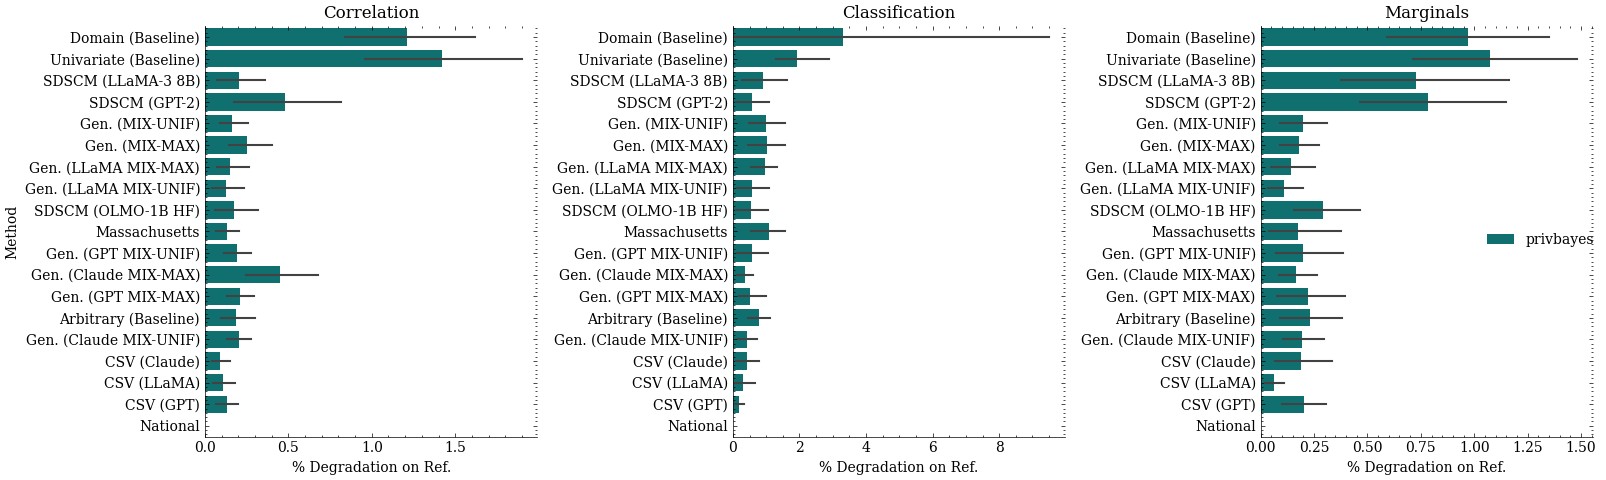

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots 

# transpose so that bars are horizontal
metric_group_map = {
    "correlation_metrics": "Correlation",
    "classification_metrics": "Classification",
    "marginals_metrics": "Marginals"
}

we_method_name_map = {
    "we/2018": "2018",
    "we/2023": "2023",
    "we/arbitrary": "Arbitrary (Baseline)",
    "we/baseline_domain": "Domain (Baseline)",
    "we/baseline_univariate": "Univariate (Baseline)",
    "we/csv-claude": "CSV (Claude)",
    "we/csv-gpt": "CSV (GPT)",
    "we/csv-llama": "CSV (LLaMA)",
    "we/gen-MIX-MAX": "Gen. (MIX-MAX)",
    "we/gen-MIX-UNIF": "Gen. (MIX-UNIF)",
    "we/gen-claude-MIX-MAX": "Gen. (Claude MIX-MAX)",
    "we/gen-claude-MIX-UNIF": "Gen. (Claude MIX-UNIF)",
    "we/gen-gpt-MIX-MAX": "Gen. (GPT MIX-MAX)",
    "we/gen-gpt-MIX-UNIF": "Gen. (GPT MIX-UNIF)",
    "we/gen-llama-MIX-MAX": "Gen. (LLaMA MIX-MAX)",
    "we/gen-llama-MIX-UNIF": "Gen. (LLaMA MIX-UNIF)",
    "we/sdscm-gpt2": "SDSCM (GPT-2)",
    "we/sdscm-llama-3-8b": "SDSCM (LLaMA-3 8B)",
    "we/sdscm-olmo-1b-hf": "SDSCM (OLMO-1B HF)"
}

acs_method_name_map = {
    "acs/arbitrary": "Arbitrary (Baseline)",
    "acs/baseline_domain": "Domain (Baseline)",
    "acs/baseline_univariate": "Univariate (Baseline)",
    "acs/csv-claude": "CSV (Claude)",
    "acs/csv-gpt": "CSV (GPT)",
    "acs/csv-llama": "CSV (LLaMA)",
    "acs/gen-MIX-MAX": "Gen. (MIX-MAX)",
    "acs/gen-MIX-UNIF": "Gen. (MIX-UNIF)",
    "acs/gen-claude-MIX-MAX": "Gen. (Claude MIX-MAX)",
    "acs/gen-claude-MIX-UNIF": "Gen. (Claude MIX-UNIF)",
    "acs/gen-gpt-MIX-MAX": "Gen. (GPT MIX-MAX)",
    "acs/gen-gpt-MIX-UNIF": "Gen. (GPT MIX-UNIF)",
    "acs/gen-llama-MIX-MAX": "Gen. (LLaMA MIX-MAX)",
    "acs/gen-llama-MIX-UNIF": "Gen. (LLaMA MIX-UNIF)",
    "acs/massachusetts_upsampled": "Massachusetts",
    "acs/national": "National",
    "acs/sdscm-gpt2": "SDSCM (GPT-2)",
    "acs/sdscm-llama-3-8b": "SDSCM (LLaMA-3 8B)",
    "acs/sdscm-olmo-1b-hf": "SDSCM (OLMO-1B HF)"
}

edad_method_name_map = {
    "edad/2020": "2020",
    "edad/2023": "2023",
    "edad/arbitrary": "Arbitrary (Baseline)",
    "edad/baseline_domain": "Domain (Baseline)",
    "edad/baseline_univariate": "Univariate (Baseline)",
    "edad/csv-claude": "CSV (Claude)",
    "edad/csv-gpt": "CSV (GPT)",
    "edad/csv-llama": "CSV (LLaMA)",
    "edad/gen-MIX-MAX": "Gen. (MIX-MAX)",
    "edad/gen-MIX-UNIF": "Gen. (MIX-UNIF)",
    "edad/gen-claude-MIX-MAX": "Gen. (Claude MIX-MAX)",
    "edad/gen-claude-MIX-UNIF": "Gen. (Claude MIX-UNIF)",
    "edad/gen-gpt-MIX-MAX": "Gen. (GPT MIX-MAX)",
    "edad/gen-gpt-MIX-UNIF": "Gen. (GPT MIX-UNIF)",
    "edad/gen-llama-MIX-MAX": "Gen. (LLaMA MIX-MAX)",
    "edad/gen-llama-MIX-UNIF": "Gen. (LLaMA MIX-UNIF)",
    "edad/sdscm-gpt2": "SDSCM (GPT-2)",
    "edad/sdscm-llama-3-8b": "SDSCM (LLaMA-3 8B)",
    "edad/sdscm-olmo-1b-hf": "SDSCM (OLMO-1B HF)"
}

rename_map = {
    "pct_degradation_on_ref": "% Degradation on Ref."
}

def facet_plot_for_data(df, method_name_map):
    df_for_plotting = df.copy()
    with plt.style.context(['science']):
        plt.rc('text', usetex=False)

        df_renamed = df_for_plotting.rename(columns=rename_map)
        df_renamed["metric_group_label"] = df_renamed["metric_group"].map(metric_group_map)
        df_renamed["dataset_name_label"] = df_renamed["dataset_name"].map(method_name_map)
        deg_col = rename_map["pct_degradation_on_ref"]
        
        for_facet_grid_df = df_renamed.sort_values(deg_col, ascending=False)
        
        plot_order = list(metric_group_map.values())

        g = sns.FacetGrid(
            for_facet_grid_df,
            col="metric_group_label",
            col_wrap=3,
            height=5,
            sharex=False,
            sharey=False,
            col_order=plot_order
        )

        palette = ['#008080', '#D8BFD8']

        g.map_dataframe(
            sns.barplot,
            x=deg_col,
            y="dataset_name_label",
            hue="synth_name",
            orient='h',
            order=for_facet_grid_df["dataset_name_label"].unique(),
            palette=palette
        )

        g.add_legend()

        g.set_axis_labels("% Degradation on Ref.", "Method")

        # set title,
        for ax, title in zip(g.axes.flatten(), plot_order):
            ax.set_title(title)

        for ax in g.axes.flatten():
            for label in ax.get_yticklabels():
                label.set_rotation(0)

        plt.tight_layout()
        plt.show()

facet_plot_for_data(for_eps_and_method_acs, acs_method_name_map)


/Users/lucasrosenblatt/opt/miniconda3/envs/fairly_uncertain/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)
/Users/lucasrosenblatt/opt/miniconda3/envs/fairly_uncertain/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)
/Users/lucasrosenblatt/opt/miniconda3/envs/fairly_uncertain/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)


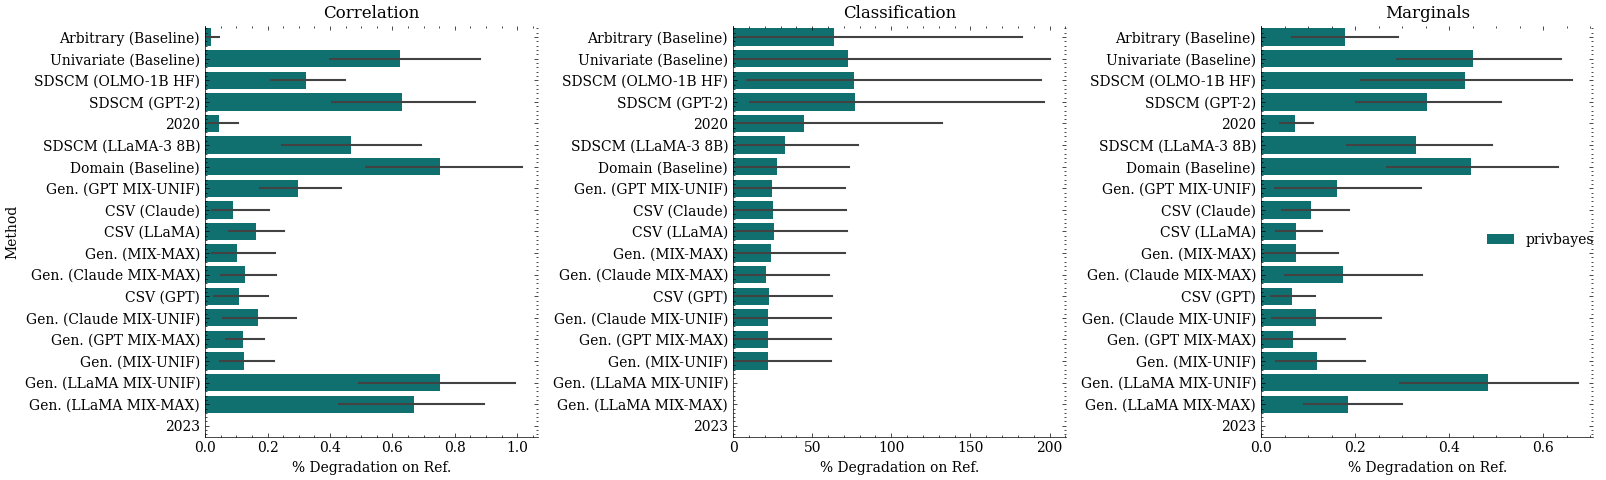

In [25]:
facet_plot_for_data(for_eps_and_method_edad, edad_method_name_map)

/Users/lucasrosenblatt/opt/miniconda3/envs/fairly_uncertain/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)
/Users/lucasrosenblatt/opt/miniconda3/envs/fairly_uncertain/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)
/Users/lucasrosenblatt/opt/miniconda3/envs/fairly_uncertain/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)


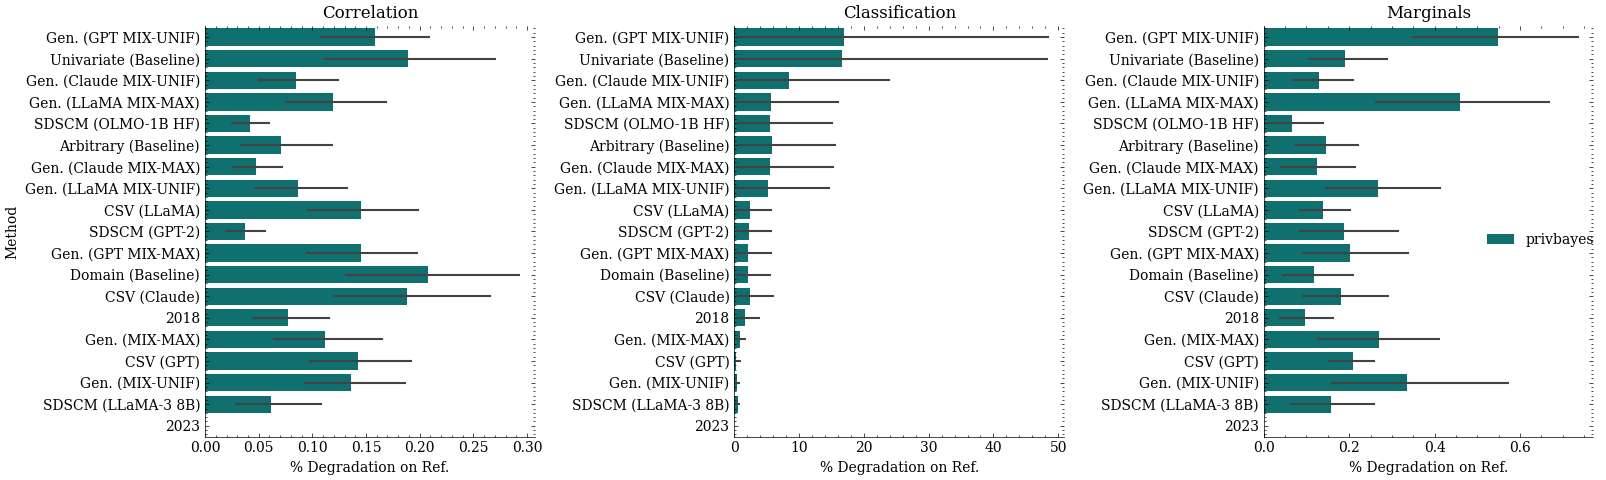

In [26]:
facet_plot_for_data(for_eps_and_method_we, we_method_name_map)

## pareto frontier analysis

In [27]:
from pandas.plotting import parallel_coordinates

def identify_pareto_frontier(df, metric_columns):
    # check for pareto frontier
    costs = df[metric_columns].values
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            # any point that is dominated by point i is not efficient
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)
            is_efficient[i] = True 
    return is_efficient

def pareto_frontier_analysis_for_df(df):
    agg_df = df.groupby(['dataset_name', 'metric_group'])['pct_degradation_on_ref'].mean().reset_index()

    pivot_df = agg_df.pivot(index='dataset_name', columns='metric_group', values='pct_degradation_on_ref').reset_index()

    pivot_df.columns.name = None
    pivot_df.rename(columns={
        'classification_metrics': 'classification',
        'marginals_metrics': 'marginals',
        'correlation_metrics': 'correlation'
    }, inplace=True)

    pivot_df = pivot_df[~pivot_df['dataset_name'].str.contains('2018')]
    pivot_df = pivot_df[~pivot_df['dataset_name'].str.contains('2023')]
    pivot_df = pivot_df[~pivot_df['dataset_name'].str.contains('national')]
    pivot_df = pivot_df[~pivot_df['dataset_name'].str.contains('massachusetts')]
    
    metric_cols = ['classification', 'marginals', 'correlation']

    pivot_df['pareto'] = identify_pareto_frontier(pivot_df, metric_cols)

    pareto_df = pivot_df[pivot_df['pareto']]
    print()
    print("these are pareto-efficient methods!")
    print(pareto_df)
    print()

    with plt.style.context(['science']):
        plt.rc('text', usetex=False)
        pivot_df['pareto_front'] = pivot_df['pareto'].apply(lambda x: 'pareto front' if x else 'non-pareto')

        plt.figure(figsize=(12, 6))
        pivot_df = pivot_df.sort_values('pareto_front', ascending=False)
        parallel_coordinates(
            pivot_df,
            class_column='pareto_front',
            cols=['classification', 'marginals', 'correlation'],
            color=('blue', 'grey'),
            linewidth=2
        )

        plt.title('parallel coordinates plot ', fontsize=15)
        plt.xlabel('metric Groups', fontsize=12)
        plt.ylabel('percent degradation on reference', fontsize=12)
        plt.yscale('log')
        plt.legend(title='method category')
        plt.grid(True)
        plt.show()


these are pareto-efficient methods!
     dataset_name  classification  correlation  marginals  pareto
3  acs/csv-claude        0.410135     0.090708   0.190554    True
4     acs/csv-gpt        0.188703     0.130271   0.202032    True
5   acs/csv-llama        0.302610     0.105341   0.061804    True



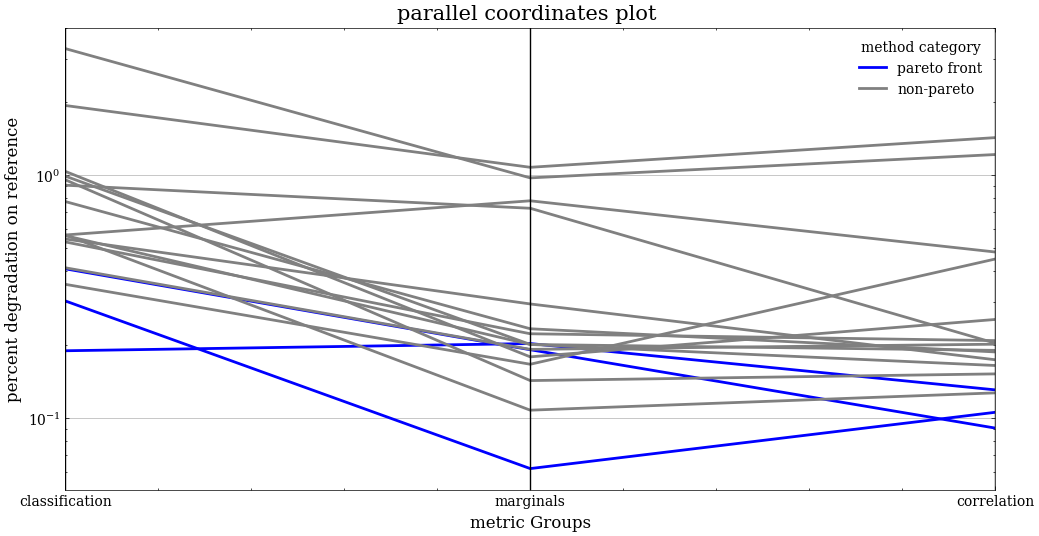

In [28]:
pareto_frontier_analysis_for_df(for_eps_and_method_acs)



these are pareto-efficient methods!
                dataset_name  classification  correlation  marginals  pareto
0                  edad/2020       45.127657     0.044839   0.072582    True
2             edad/arbitrary       63.606997     0.018922   0.178524    True
5            edad/csv-claude       25.447186     0.089040   0.106960    True
6               edad/csv-gpt       22.937310     0.108256   0.065748    True
8           edad/gen-MIX-MAX       24.290106     0.103803   0.074576    True
9          edad/gen-MIX-UNIF       21.932477     0.125437   0.119294    True
10   edad/gen-claude-MIX-MAX       20.713699     0.128092   0.174845    True
11  edad/gen-claude-MIX-UNIF       21.969253     0.169184   0.117276    True
12      edad/gen-gpt-MIX-MAX       22.365549     0.121626   0.067636    True



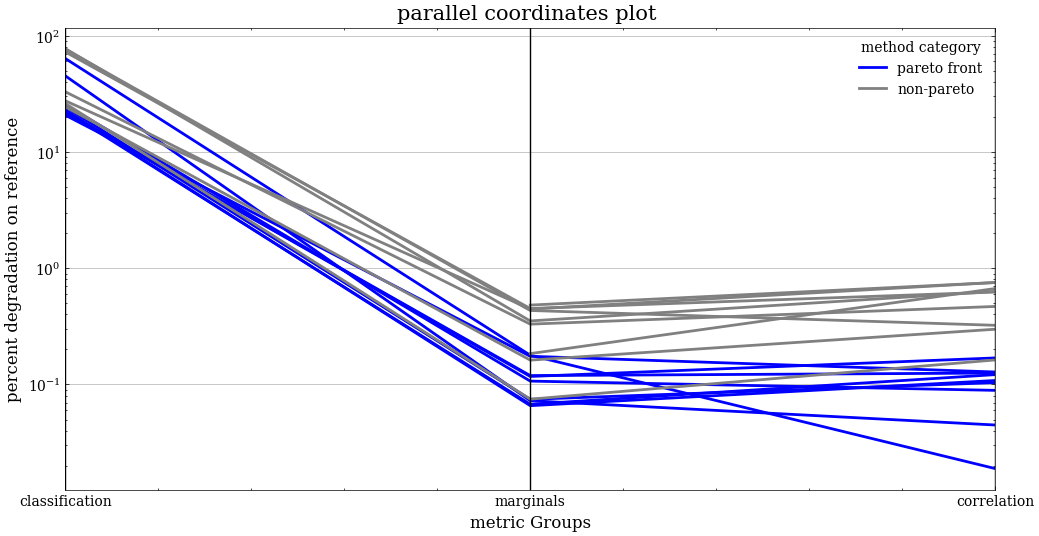

In [29]:
pareto_frontier_analysis_for_df(for_eps_and_method_edad)


these are pareto-efficient methods!
           dataset_name  classification  correlation  marginals  pareto
3    we/baseline_domain        2.102968     0.208090   0.117451    True
6            we/csv-gpt        0.308579     0.142413   0.208085    True
7          we/csv-llama        2.340504     0.145786   0.139841    True
9       we/gen-MIX-UNIF        0.384137     0.136224   0.335866    True
16        we/sdscm-gpt2        2.209941     0.037328   0.188760    True
17  we/sdscm-llama-3-8b        0.495892     0.061436   0.157512    True
18  we/sdscm-olmo-1b-hf        5.442762     0.041778   0.065765    True



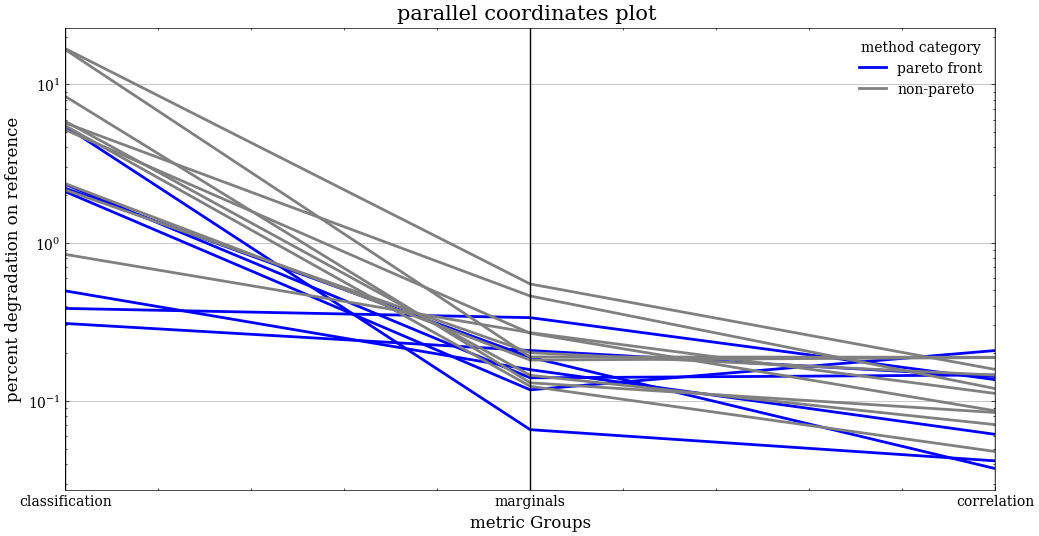

In [30]:
pareto_frontier_analysis_for_df(for_eps_and_method_we)


## Generating Table Latex

\begin{table}[t!]
    \centering
    \caption{WE Metrics}
    \label{tab:all_metrics_we}
    \resizebox{\linewidth}{!}{%
    \begin{tabular}{lccc}
    \toprule
    Method & pct_degradation_on_ref_class & pct_degradation_on_ref_corr & pct_degradation_on_ref_marg \\
    \midrule
    we/csv-gpt & \cellcolor{gold!30}0.309 & 0.142 & 0.208 \\
    we/gen-MIX-UNIF & \cellcolor{silver!30}0.384 & 0.136 & 0.336 \\
    we/sdscm-llama-3-8b & \cellcolor{bronze!30}0.496 & 0.061 & 0.158 \\
    we/gen-MIX-MAX & 0.843 & 0.111 & 0.270 \\
    we/2018 & 1.694 & 0.077 & \cellcolor{silver!30}0.097 \\
    we/baseline_domain & 2.103 & 0.208 & \cellcolor{bronze!30}0.117 \\
    we/gen-gpt-MIX-MAX & 2.157 & 0.145 & 0.202 \\
    we/sdscm-gpt2 & 2.210 & \cellcolor{gold!30}0.037 & 0.189 \\
    we/csv-llama & 2.341 & 0.146 & 0.140 \\
    we/csv-claude & 2.362 & 0.188 & 0.181 \\
    we/gen-llama-MIX-UNIF & 5.172 & 0.087 & 0.268 \\
    we/sdscm-olmo-1b-hf & 5.443 & \cellcolor{silver!30}0.042 & \cellcolor{gold!30}0.066 